In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
import os

# --- Parameters ---
# We'll use a 1-year rolling window for our calculations
WINDOW = 252 
# Confidence levels for VaR
VAR_LEVELS = [95, 99] 
# Alpha levels for VaR calculation (e.g., 5% for 95% VaR)
ALPHAS = [1 - level / 100 for level in VAR_LEVELS] 
# Confidence level for Expected Shortfall (as per Basel)
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# --- Load Data ---
DATA_DIR = "data"
portfolio_returns_path = os.path.join(DATA_DIR, "portfolio_log_returns.csv")
returns = pd.read_csv(portfolio_returns_path, index_col='Date', parse_dates=True)

print("Successfully loaded portfolio returns.")
print(returns.head())

Successfully loaded portfolio returns.
            EqualWeightPortfolio
Date                            
2007-04-12              0.005627
2007-04-13              0.000587
2007-04-16              0.005247
2007-04-17             -0.000047
2007-04-18              0.003596


### Historical VaR


Calculated Historical VaR and ES:
            HistVaR_95  HistVaR_99  HistES_97.5
Date                                           
2008-04-10   -0.018920   -0.025662    -0.025539
2008-04-11   -0.019095   -0.026285    -0.027030
2008-04-14   -0.019095   -0.026285    -0.027030
2008-04-15   -0.019095   -0.026285    -0.027030
2008-04-16   -0.019095   -0.026285    -0.027030


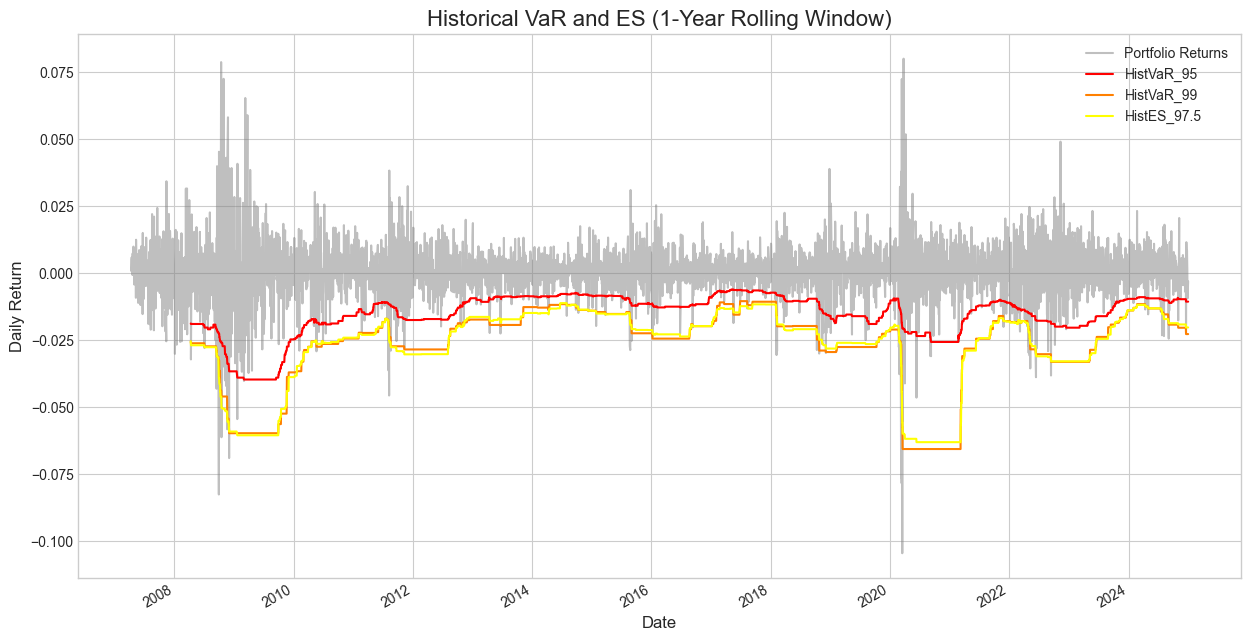

In [5]:
# --- Historical VaR Calculation ---
# This part is correct and remains unchanged
historical_vars = {}
for alpha in ALPHAS:
    level = int(100 * (1 - alpha))
    historical_vars[level] = returns.rolling(window=WINDOW).quantile(alpha)
    historical_vars[level].rename(columns={'EqualWeightPortfolio': f'HistVaR_{level}'}, inplace=True)

# --- Historical ES Calculation (Corrected) ---
rolling_returns = returns.rolling(window=WINDOW)
historical_var_975 = returns.rolling(window=WINDOW).quantile(ES_ALPHA)

# THE FIX: We add .iloc[0] to extract the scalar VaR value for the comparison.
historical_es_975 = rolling_returns.apply(
    lambda x: x[x < historical_var_975.loc[x.index[-1]]['EqualWeightPortfolio']].mean(),
    raw=False
).rename(columns={'EqualWeightPortfolio': 'HistES_97.5'})


# --- Combine and Display Results ---
hist_risk_measures = pd.concat([var for var in historical_vars.values()] + [historical_es_975], axis=1).dropna()

print("\nCalculated Historical VaR and ES:")
print(hist_risk_measures.head())

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

returns['EqualWeightPortfolio'].plot(ax=ax, color='gray', alpha=0.5, label='Portfolio Returns')
hist_risk_measures.plot(ax=ax, colormap='autumn')

ax.set_title('Historical VaR and ES (1-Year Rolling Window)', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.show()

### **Parametric VaR** (also known as Variance-Covariance VaR) is calculated using the formula:

VaR_alpha = mu + sigma * Z_alpha

Where:  
- `mu` is the **mean return**  
- `sigma` is the **standard deviation**  
- `Z_alpha` is the **inverse cumulative distribution function (CDF)** of a standard normal distribution at a given confidence level `alpha`



Calculated Parametric (Normal) VaR and ES:
            ParamVaR_Norm_95  ParamVaR_Norm_99  ParamES_Norm_97.5
Date                                                             
2008-04-10         -0.016893         -0.024052          -0.024172
2008-04-11         -0.017363         -0.024655          -0.024778
2008-04-14         -0.017395         -0.024690          -0.024813
2008-04-15         -0.017396         -0.024690          -0.024813
2008-04-16         -0.017451         -0.024803          -0.024927


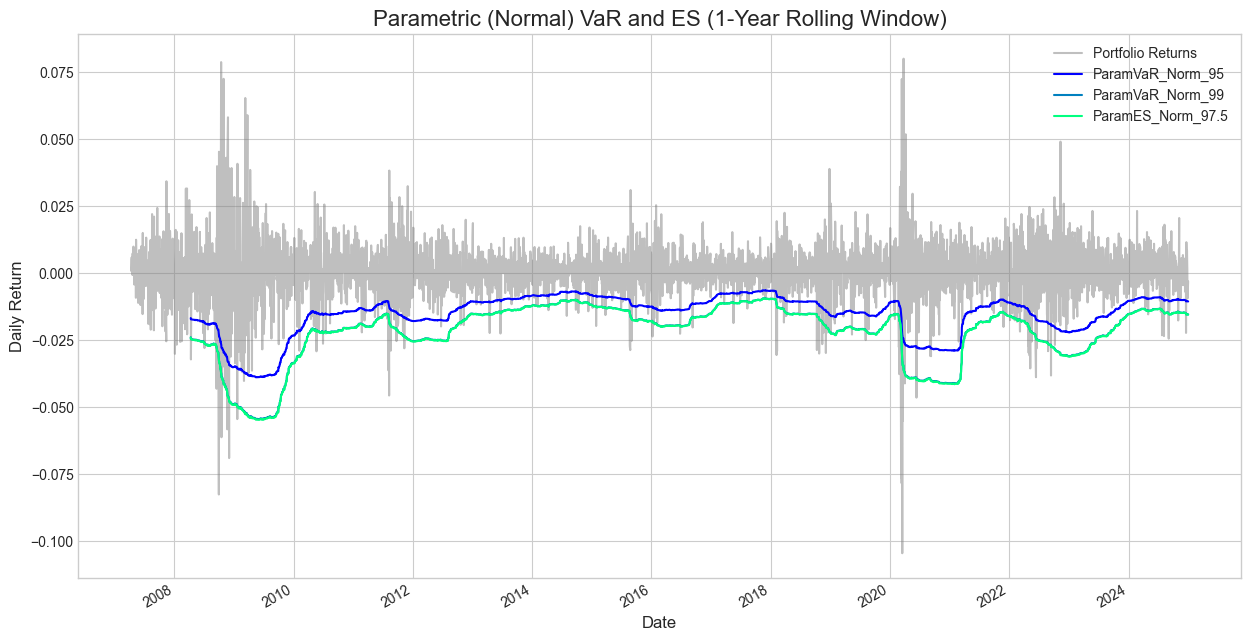

In [6]:
from scipy.stats import norm

# --- Parametric VaR (Normal) Calculation ---
# Calculate rolling mean and standard deviation
rolling_mean = returns.rolling(window=WINDOW).mean()
rolling_std = returns.rolling(window=WINDOW).std()

# Calculate VaR
parametric_vars = {}
for alpha, level in zip(ALPHAS, VAR_LEVELS):
    # Z-score for the given confidence level
    z_score = norm.ppf(alpha)
    parametric_vars[level] = rolling_mean + rolling_std * z_score
    parametric_vars[level].rename(columns={'EqualWeightPortfolio': f'ParamVaR_Norm_{level}'}, inplace=True)

# --- Parametric ES (Normal) Calculation ---
# Formula for ES under normal distribution assumption
z_es = -norm.pdf(norm.ppf(ES_ALPHA)) / ES_ALPHA
parametric_es_975 = rolling_mean + rolling_std * z_es
parametric_es_975.rename(columns={'EqualWeightPortfolio': 'ParamES_Norm_97.5'}, inplace=True)


# --- Combine and Display Results ---
param_risk_measures = pd.concat(
    [var for var in parametric_vars.values()] + [parametric_es_975], 
    axis=1
).dropna()

print("\nCalculated Parametric (Normal) VaR and ES:")
print(param_risk_measures.head())

# --- Plot the results ---
fig, ax = plt.subplots(figsize=(15, 8))

returns['EqualWeightPortfolio'].plot(ax=ax, color='gray', alpha=0.5, label='Portfolio Returns')
param_risk_measures.plot(ax=ax, colormap='winter')

ax.set_title('Parametric (Normal) VaR and ES (1-Year Rolling Window)', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.show()